### Import and configure modules

In [203]:
# John Carther V. Lao
# Import libraries
import os
import time
import PIL.Image
import functools
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import IPython.display as display

# Load compressed models from tensorflow_hub
#os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# define matplotlib parameters
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

<font size="5">***Machine Learning Step: Gathering Data***</font>

In [204]:
# define file path
content_path = "C:\\Users\\Carther\\Desktop\\COE_HW2\\TIP_Pic.jpg"
style_path = "C:\\Users\\Carther\\Desktop\\COE_HW2\\Ukiyo-e.jpg"

<font size="5">***Machine Learning Step: Data Preprocessing***</font>

<font size="3">***Visualize the Input***</font>

In [205]:
# Define a function to load an image and limit its maximum dimension to 512 pixels.
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [206]:
# Define a function to turn tensor data to image
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [207]:
# Create a simple function to display an image
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

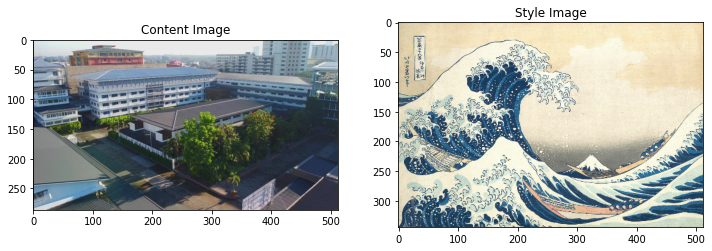

In [208]:
# display said images
content_image = load_img(content_path)
style_image = load_img(style_path)

#plot image
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

<font size="3">***Define content and style representations***</font>

In [209]:
# set up parameters for VGG19
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [210]:
# load a `VGG19` without the classification head, and list the layer names
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_26
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [211]:
# Choose intermediate layers from the network to represent the style and content of the image
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

<font size="5">***Machine Learning Step: Model Creation***</font>

In [212]:
# define a function builds a VGG19 model that returns a list of intermediate layer outputs
def vgg_layers(layer_names):
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [213]:
# create the model
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 344, 512, 64)
  min:  0.0
  max:  827.922
  mean:  37.736057

block2_conv1
  shape:  (1, 172, 256, 128)
  min:  0.0
  max:  4189.405
  mean:  226.68774

block3_conv1
  shape:  (1, 86, 128, 256)
  min:  0.0
  max:  9504.849
  mean:  204.49513

block4_conv1
  shape:  (1, 43, 64, 512)
  min:  0.0
  max:  22437.146
  mean:  782.508

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  2924.7756
  mean:  57.539898



In [214]:
# define a function that calculate style
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [215]:
# extract style from image functions

# initialize model
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [216]:
# returns the gram matrix (style) of the `style_layers` and content of the `content_layers`
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.052376863
    max:  15855.278
    mean:  505.87192

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  111882.47
    mean:  15729.449

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  383264.16
    mean:  16511.375

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  5120678.5
    mean:  235370.88

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  131512.8
    mean:  1749.0945

Contents:
   block5_conv2
    shape:  (1, 17, 32, 512)
    min:  0.0
    max:  1082.0116
    mean:  16.22038


<font size="3">***Run Gradient Descent***</font>

In [217]:
# extract content and style image
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [218]:
# contatin image to df
image = tf.Variable(content_image)

In [219]:
# define a function to keep the pixel values between 0 and 1
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [220]:
# Create an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [221]:
# use a weighted combination of the two losses to get the total loss
style_weight=1e-2
content_weight=1e4

In [222]:
# define function to get loss
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [223]:
# define a function to update content image to style
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

<font size="5">***Machine Learning Step: Train Model***</font>

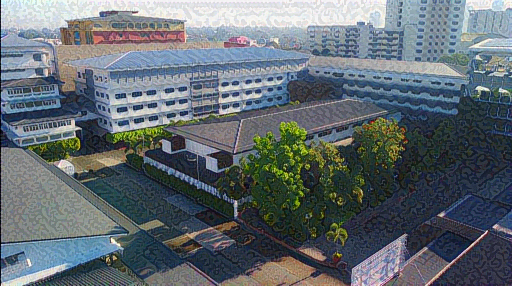

In [224]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

<font size="5">***Machine Learning Step: Evaluate Model***</font>

<font size="3">***Run Gradient Descent***</font>

In [225]:
# define function to get image deltas
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

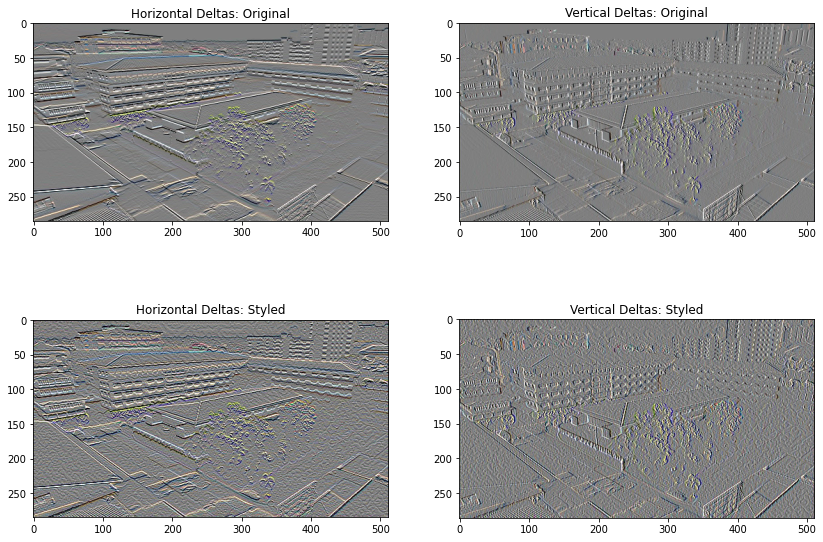

In [226]:
# plot content deltas to get edges of images
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [227]:
# calculate stylization loss
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [228]:
total_variation_loss(image).numpy()

52727.598

<font size="5">***Machine Learning Step: Hyperparameter Tuning***</font>

In [229]:
total_variation_weight=30

In [230]:
# include in the `train_step` function
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

<font size="5">***Machine Learning Step: Start Prediction of Stylized Image***</font>

In [231]:
# Reinitialize the image-variable and the optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

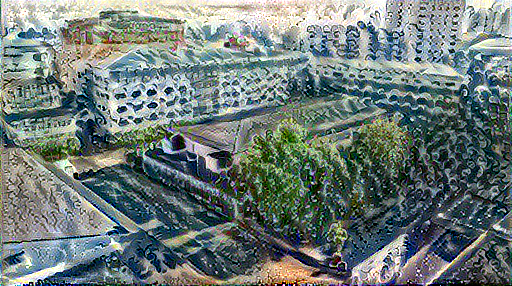

Train step: 120
Total time: 228.3


In [232]:
# start optimization
import time
start = time.time()

epochs = 20
steps_per_epoch = 6

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [233]:
#save image as png
file_name = 'C:\\Users\\Carther\\Desktop\\COE_HW2\\stylized-Ukiyo-e.png'
tensor_to_image(image).save(file_name)